# ScaleSpikeSlab (S^3)

This scripts contain algorithms in Python for Scalable Spike-and-Slab (S^3), a scalable Gibbs sampling implementation for high-dimensional Bayesian regression with the continuous spike-and-slab prior.

It is based on the article "Scalable Spike-and-Slab", by Niloy Biswas, Lester Mackey and Xiao-Li Meng.

## A tutorial with GWAS data

### Run MCMC with S3

In [2]:
# !cd 'gdrive/My Drive/Niloy_Files/github/ScaleSpikeSlab/Python'

In [26]:
# Riboflavin linear regression dataset of Buhlmann et al. (2014)
from S3 import ScaleSpikeSlab, SpikeSlabPrior, ModelType
import pandas as pd

riboflavin = pd.read_csv('riboflavin.csv')
y = riboflavin['y'].to_numpy()
X = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()
X = (X-X.mean(axis=0))/X.std(axis=0)

ss_prior = SpikeSlabPrior(
    model_type=ModelType.LINEAR,
    q=0.05,
    tau0=1e-5,
    tau1=1,
    a0=1,
    b0=1
)
s3_model = ScaleSpikeSlab(endog=y, exog=X, model=ModelType.LINEAR, prior=ss_prior)
mcmc_out = s3_model.run_mcmc(chain_length = 2000, burnin = 1000, store_trajectory = True)

#### Plot Spike-and-Slab posterior probabiliies $P(z_i=1|y)$ for variable selection and posterior means $E[\beta_i|y]$ 

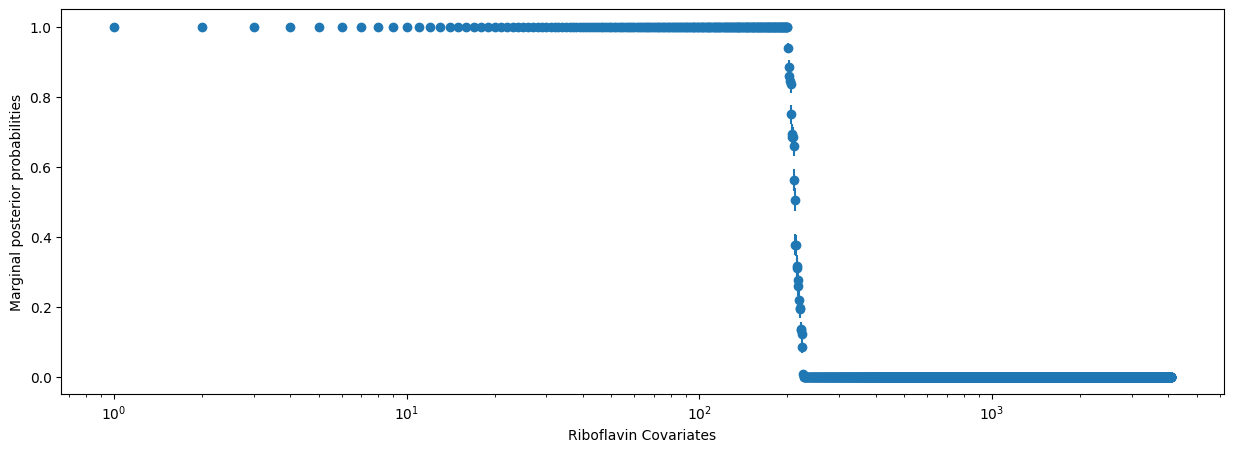

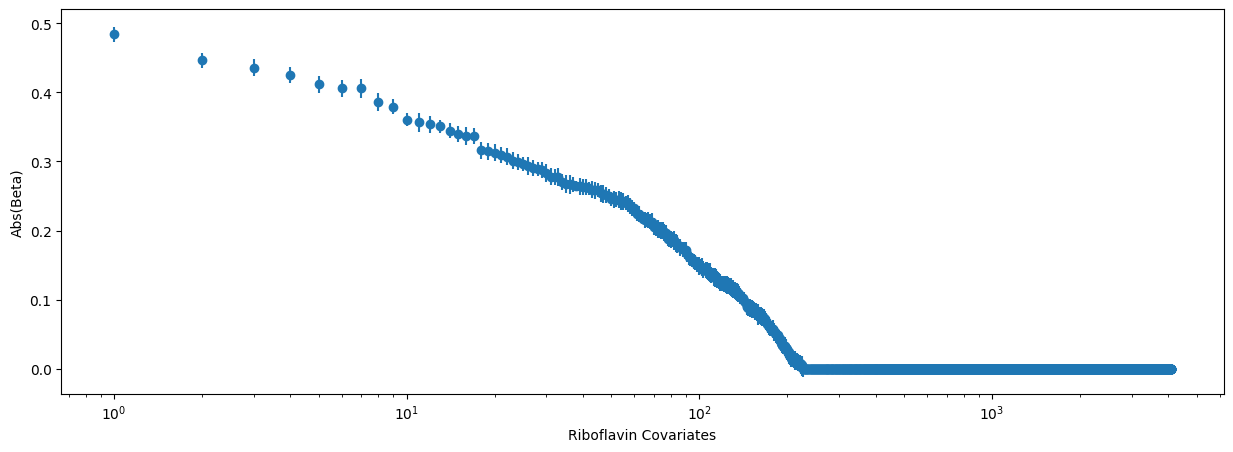

In [30]:
import numpy as np
import matplotlib.pyplot as plt

z_sorted_indices = np.argsort(mcmc_out['z'].mean(axis=0))[::-1]
z_means = mcmc_out['z'].mean(axis=0)[z_sorted_indices]
z_stds = (mcmc_out['z'].std(axis=0)/mcmc_out['z'].shape[0]**0.5)[z_sorted_indices]

plt.figure(figsize=(15,5))
plt.errorbar(x=np.arange(len(z_means))+1, y=z_means, yerr=2*z_stds, fmt='o')
plt.xscale('log')
plt.xlabel('Riboflavin Covariates')
plt.ylabel('Marginal posterior probabilities')
plt.show()

beta_sorted_indices = np.argsort(abs(mcmc_out['beta'].mean(axis=0)))[::-1]
beta_means = mcmc_out['beta'].mean(axis=0)[beta_sorted_indices]
beta_stds = (mcmc_out['beta'].std(axis=0)/mcmc_out['beta'].shape[0]**0.5)[beta_sorted_indices]
plt.figure(figsize=(15,5))
plt.errorbar(x=np.arange(len(beta_means))+1, y=abs(beta_means), yerr=2*beta_stds/(mcmc_out['beta'].shape[0]**0.5), fmt='o')
plt.xscale('log')
plt.xlabel('Riboflavin Covariates')
plt.ylabel('Abs(Beta)')
plt.show()


#### Plot Spike-and-Slab marginal posterior probabilities for variable selection

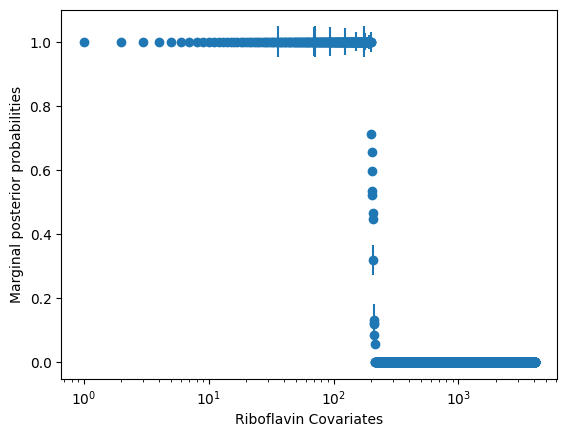

In [126]:
import numpy as np
import matplotlib.pyplot as plt


beta_sorted_indices = np.argsort(abs(mcmc_out['beta'].mean(axis=0)))[::-1]
beta_means = mcmc_out['beta'].mean(axis=0)[beta_sorted_indices]
beta_stds = (mcmc_out['beta'].std(axis=0)/mcmc_out['beta'].shape[0]**0.5)[beta_sorted_indices]


sorted_indices = np.argsort(np.mean(mcmc_out['z'], axis=0))[::-1]
z_means = np.mean(mcmc_out['z'], axis=0)[sorted_indices]
z_sds = (mcmc_out['z'].std(axis=0)/mcmc_out['z'].shape[0]**0.5)[beta_sorted_indices]
\
plt.errorbar(x=np.arange(len(z_means))+1, y=z_means, yerr=3*z_sds,fmt='o')
plt.xscale('log')
plt.xlabel('Riboflavin Covariates')
plt.ylabel('Marginal posterior probabilities')
plt.show()